### Libraries

In [1]:
import re
import os
import sys
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython.display import Image, display

pd.options.plotting.backend = "matplotlib"

# Load NASInterface for model instantiation purposes (bare bones NASSearchSpace and NASEval, no memory consumption)
from helpers.instantiation_interface import instantiate_network

### Macros

#### File-Handling Macros

In [48]:
''' Input/Output file related macros '''

CONFIG_VERSION_BASELINE = 'hivenas_a'
CONFIG_VERSION_AUG = 'hivenas_aug_a'
CONFIG_VERSION_CUTOUT = 'res_cutout_2' # 'hivenas_aug_cutout_1'
CONFIG_VERSION_RES = 'res_aug_2' # 'hivenas_res_aug_cutout_1'
CONFIG_VERSION_ACT = 'act_res_aug_cutout_1'
CONFIG_VERSION_MEA = 'act_res_aug_cutout_ma'

RESULTS_PATH = './src/res/archived results/'
ANALYSIS_RESULTS_PATH = './src/analysis/images/'

if not os.path.exists(ANALYSIS_RESULTS_PATH):
    os.makedirs(ANALYSIS_RESULTS_PATH)
    
    
def get_file_path(config, file_extension):
    ''' Returns relative path for a given filename and configuration version '''
    
    f_path = os.path.join(RESULTS_PATH, config)
    f_path = os.path.join(f_path, config + f'.{file_extension}')
    
    return f_path


def get_all_paths(config, directory, endswith='.pickle'):
    ''' Returns a list of paths for all files in a given directory and configuration version '''
    
    paths = []
    root_dir = os.path.join(RESULTS_PATH, config)
    root_dir = os.path.join(root_dir, directory)
    
    for root, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(endswith):
                paths.append((os.path.join(root, filename), filename))

    return paths


# Instantiate main dataframes
main_dfs = {
    'baseline': dict.fromkeys({'logs', 'data', 'hist', 'config', 'name'}),
    'aug': dict.fromkeys({'logs', 'data', 'hist', 'config', 'name'}),
    'res': dict.fromkeys({'logs', 'data', 'hist', 'config', 'name'}),
    'co': dict.fromkeys({'logs', 'data', 'hist', 'config', 'name'}),
    'act': dict.fromkeys({'logs', 'data', 'hist', 'config', 'name'}),
    'mea': dict.fromkeys({'logs', 'data', 'hist', 'config', 'name'}) 
}

# Set configuration versions
main_dfs['baseline']['config'] = CONFIG_VERSION_BASELINE
main_dfs['aug']['config'] = CONFIG_VERSION_AUG
main_dfs['res']['config'] = CONFIG_VERSION_RES
main_dfs['co']['config'] = CONFIG_VERSION_CUTOUT
main_dfs['act']['config'] = CONFIG_VERSION_ACT
main_dfs['mea']['config'] = CONFIG_VERSION_MEA

# Set titles for plot legends, etc...
main_dfs['baseline']['name'] = 'HiveNAS'
main_dfs['aug']['name'] = 'HiveNAS+Aug'
main_dfs['res']['name'] = 'HiveNAS+ResNets'
main_dfs['co']['name'] = 'HiveNAS+Cutout'
main_dfs['act']['name'] = 'HiveNAS+ACT'
main_dfs['mea']['name'] = 'HiveANS+MEA'

#### Data Analysis Macros

In [49]:
''' Data analysis and processing related macros '''

TRACE_COLORS = [
    'rgba(230,126,34,1.0)',
    'rgba(52,152,219,1.0)',
    'rgba(39,174,96,1.0)',
    'rgba(155,89,182,1.0)',
    'rgba(241,196,15,1.0)',
    'rgba(52,73,94,1.0)'
]

TRACE_DOTTED_COLORS = [
    'rgba(230,126,34,0.5)',
    'rgba(52,152,219,0.5)',
    'rgba(39,174,96,0.5)',
    'rgba(155,89,182,0.5)',
    'rgba(241,196,15,0.5)',
    'rgba(52,73,94,0.5)'
]

GRID_LINE_COLOR = 'rgba(189,195,199,0.75)'
GRID_ZERO_LINE_COLOR = 'rgba(189,195,199,1.0)'
PLOT_TEXT_COLOR = 'rgba(44,62,80,1.0)'


def reject_outliers(data, m=1.5):
    ''' Prunes data points outside m standard deviations '''
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def truncate_lists(lists):
    ''' Truncates the given lists (or dict of lists) to the shortest length (plot aesthetic purposes) '''
    
    if type(lists) is dict:
        shortest_len = min([len(ls) for _, ls in lists.items()])
        for k, ls in lists.items():
            lists[k] = ls[:shortest_len]
            
    shortest_len = min([len(ls) for ls in lists])
    lists = [ls[:shortest_len] for ls in lists]



### Data Structuring and Manipulation

#### Log File

In [50]:
def get_log_df(config):
    ''' Loads and structures a log file (raw) into a DF '''
    
    # Get raw file str
    f_path = get_file_path(config, 'log')
    
    raw_file = ''
    
    if not os.path.exists(f_path):
        return pd.DataFrame()
    
    with open(f_path) as f:
        for line in f:
            raw_file += line

    # Extract evaluation logs by tag
    evals = raw_file.split('EVALUATION LOG:')
    evals.pop(0)

    log_df = pd.DataFrame()

    # Format raw text and populate dataframe
    eval_idx = 0
    itr = 1
    for e in evals:
        arch = re.search('(?<=Candidate \().+?(?=\))', e).group(0)
        val_acc = re.findall('(?<=val_sparse_categorical_accuracy: )[0-9]+\.[0-9]+', e)
        val_loss = re.findall('(?<=val_loss: )[0-9]+\.[0-9]+', e)
        train_acc = re.findall('(?<= sparse_categorical_accuracy: )[0-9]+\.[0-9]+', e)
        train_loss = re.findall('(?<= loss: )[0-9]+\.[0-9]+', e)
        
        # matching criteria for training loss/acc is = to test data criteria ; pop last train items
        test_acc = train_acc.pop()
        test_loss = train_loss.pop()
        
        for i in range(len(val_acc)):
            series = pd.Series({
                'arch': arch,
                'epoch': i + 1,
                'val_acc': val_acc[i],
                'val_loss': val_loss[i],
                'train_acc': train_acc[i],
                'train_loss': train_loss[i],
                'test_acc': test_acc,
                'test_loss': test_loss,
                'eval_idx': int(eval_idx),
                'type': e.split(' ')[1],
                'bee_id': int(e.split(' ')[3].strip('()')),
                'itr': int(itr)
            })
            log_df = log_df.append(series, ignore_index=True)

        eval_idx += 1

        if e.find('itr: ') != -1:
            itr += 1

    # Standardize types
    keys_int = ['itr', 'bee_id', 'eval_idx', 'epoch']
    keys_float = ['val_acc', 'val_loss', 'train_acc', 'train_loss', 'test_loss', 'test_acc']

    for key in keys_int:
        log_df[key] = log_df[key].astype(int)

    for key in keys_float:
        log_df[key] = log_df[key].astype(float)

    return log_df


for k, df in main_dfs.items():
    main_dfs[k]['logs'] = get_log_df(main_dfs[k]['config'])
    
# Test data extraction
print(main_dfs['baseline']['logs'], '\n\n')
print(main_dfs['act']['logs'])

                                                  arch  epoch  val_acc  \
0    input|sep5x5_128|sep3x3_32|avg_pool3x3|sep5x5_...      1   0.5441   
1    input|sep5x5_128|sep3x3_32|avg_pool3x3|sep5x5_...      2   0.6463   
2    input|sep5x5_128|sep3x3_32|avg_pool3x3|sep5x5_...      3   0.6679   
3    input|sep5x5_128|sep3x3_32|avg_pool3x3|sep5x5_...      4   0.7018   
4    input|sep5x5_128|sep3x3_32|avg_pool3x3|sep5x5_...      5   0.7029   
..                                                 ...    ...      ...   
310  input|sep5x5_32|sep3x3_32|sep3x3_64|dropout|ou...      1   0.5197   
311  input|sep5x5_32|sep3x3_32|sep3x3_64|dropout|ou...      2   0.6027   
312  input|sep5x5_32|sep3x3_32|sep3x3_64|dropout|ou...      3   0.6623   
313  input|sep5x5_32|sep3x3_32|sep3x3_64|dropout|ou...      4   0.6771   
314  input|sep5x5_32|sep3x3_32|sep3x3_64|dropout|ou...      5   0.6753   

     val_loss  train_acc  train_loss  test_acc  test_loss  eval_idx  \
0      1.2490     0.4450      1.5248    

#### Main Results File

In [51]:
for k, df in main_dfs.items():
    if not os.path.exists(get_file_path(main_dfs[k]['config'], 'csv')):
        main_dfs[k]['data'] = pd.DataFrame()
        continue
        
    main_dfs[k]['data'] = pd.read_csv(get_file_path(main_dfs[k]['config'], 'csv'), header=0, index_col=0)

# Test data extraction
print(main_dfs['baseline']['data'], '\n\n')
print(main_dfs['act']['data'])

       bee_type  bee_id bee_parent  itr  \
0   EmployeeBee     0.0          -  0.0   
1   EmployeeBee     1.0          -  0.0   
2   EmployeeBee     2.0          -  0.0   
3   OnlookerBee     0.0          0  0.0   
4   OnlookerBee     1.0          0  0.0   
..          ...     ...        ...  ...   
58  EmployeeBee     2.0          -  8.0   
59  OnlookerBee     0.0          1  8.0   
60  OnlookerBee     1.0          2  8.0   
61  OnlookerBee     2.0          2  8.0   
62  OnlookerBee     3.0          0  8.0   

                                            candidate  fitness  \
0   input|sep5x5_128|sep3x3_32|avg_pool3x3|sep5x5_...   0.7100   
1   input|dropout|sep5x5_128|sep5x5_128|sep3x3_128...   0.6957   
2   input|sep5x5_32|sep3x3_32|sep5x5_128|sep5x5_12...   0.6742   
3   input|sep3x3_64|sep3x3_32|avg_pool3x3|sep5x5_1...   0.7034   
4   input|sep5x5_128|sep3x3_32|avg_pool3x3|avg_poo...   0.7125   
..                                                ...      ...   
58  input|sep5x5_128|

#### Training History Files

In [52]:
def get_pickle_df(config, main_df):
    ''' Loads and structures training hisotry pickle files '''
    
    paths = get_all_paths(config, 'training_history')
    
    if len(paths) == 0:
        return pd.DataFrame()
    
    # Load pickles into DFs
    ret_df = pd.DataFrame()
    
    for (path, filename) in paths:
        pckl = None
        with open(path, 'rb') as f:
            pckl = pickle.load(f)
        temp_df = pd.DataFrame(pckl).reset_index().rename(columns={'index': 'epoch'})
        
        filename = filename.split('.')[0]
        
        temp_df['filename'] = filename
        temp_df['epoch'] = temp_df['epoch'].apply(lambda e: e+1)
        if not len(main_df.loc[main_df['weights_filename'] == filename + '.h5']):
            # orphan weights file
            continue
        temp_df['arch'] = main_df.loc[main_df['weights_filename'] == filename + '.h5']['candidate'].values[0]
        
        ret_df = pd.concat([ret_df, temp_df])
        
    return ret_df.reset_index(drop=True)
        
    
for k, df in main_dfs.items():
    main_dfs[k]['hist'] = get_pickle_df(main_dfs[k]['config'], main_dfs[k]['data'])
    
# Test data extraction
print(main_dfs['baseline']['hist'], '\n\n')
print(main_dfs['act']['hist'])


     epoch      loss  sparse_categorical_accuracy  val_loss  \
0        1  1.475623                     0.460225  1.460599   
1        2  1.059200                     0.617950  0.991109   
2        3  0.829793                     0.706475  0.877863   
3        4  0.630564                     0.777000  0.873035   
4        5  0.410721                     0.855125  0.940298   
..     ...       ...                          ...       ...   
310      1  2.302844                     0.098825  2.302775   
311      2  2.302657                     0.099825  2.302778   
312      3  2.302686                     0.098175  2.302868   
313      4  2.302672                     0.101575  2.302859   
314      5  2.302673                     0.100250  2.302806   

     val_sparse_categorical_accuracy  \
0                             0.4674   
1                             0.6435   
2                             0.6876   
3                             0.7061   
4                             0.7030   
.. 

### Data Analysis

#### Accuracies Comparison

In [53]:
''' Comparing all models' accuracies (inconsistent at the moment) '''

# Indices included in this analysis
dfs_idx = [0, 1, 2, 3, 4]

# Data manipulation
acc = {}
for (idx, (k, df)) in enumerate(main_dfs.items()):
    if idx not in dfs_idx:
        continue
        
    if main_dfs[k]['data'].empty:
        print(f'Skipping {main_dfs[k]["name"]}, no data file found...\n')
        continue
    
    acc[main_dfs[k]['name']] = main_dfs[k]['logs'].groupby('arch')['test_acc'].max().values
    #acc[main_dfs[k]['name']] = reject_outliers(acc[main_dfs[k]['name']])
    
    
# Truncate data lengths to match (for aesthetic purposes)
truncate_lists(acc)

# Figure customization
fig = go.Figure()
fig.update_layout(
    title='HiveNAS Variations Accuracies',
    xaxis_title='Neural Architecture Index', 
    yaxis_title='Validation Acc. (%)',
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=500
)

fig.update_yaxes(tickformat=',.0%',
                 # flatten data for range extrapolation
                 range=[min([item for _,ls in acc.items() for item in ls]) * 1.1, 
                        max([item for _,ls in acc.items() for item in ls]) * 1.225],
                 color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)

fig.update_xaxes(color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)

for idx, (name, trace_data) in enumerate(acc.items()):
    # Traces
    fig.add_trace(go.Scatter(x=list(range(len(trace_data))), y=trace_data,
                             mode='lines',
                             name=name,
                             line=dict(color=TRACE_COLORS[idx])))
    fig.add_trace(go.Scatter(x=list(range(len(trace_data))), y=[trace_data.mean() for _ in range(len(trace_data))],
                             mode='lines',
                             name=f'{name} (mean)',
                             line=dict(color=TRACE_DOTTED_COLORS[idx], dash='dot')))


fig.write_image(ANALYSIS_RESULTS_PATH + 'accuracies.eps')

fig.show()

#### Architecture Diagrams

HiveNAS's top architecture (input|sep3x3_128|sep3x3_128|max_pool3x3|sep5x5_64|output)



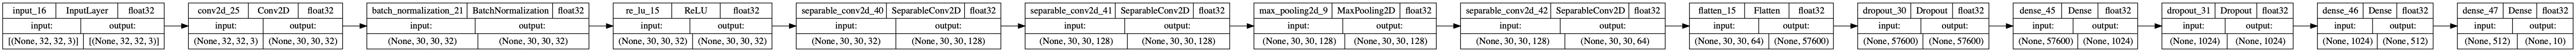



HiveNAS+Aug's top architecture (input|sep5x5_64|sep3x3_64|max_pool3x3|sep5x5_128|output)



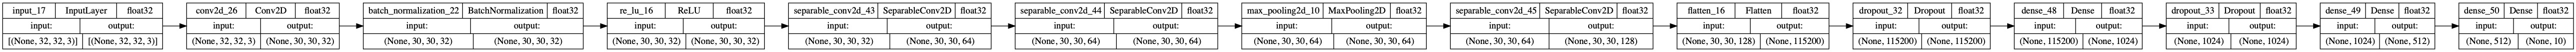



HiveNAS+ResNets's top architecture (input|avg_pool3x3|max_pool3x3|sep3x3_32|sep5x5_32|output)



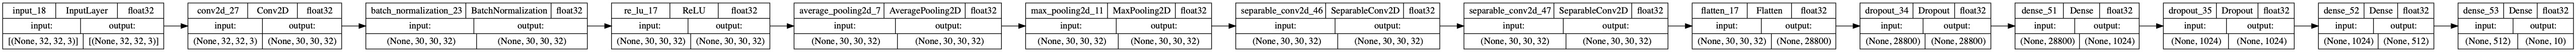



HiveNAS+Cutout's top architecture (input|sep3x3_16|batch_norm|avg_pool3x3|output)



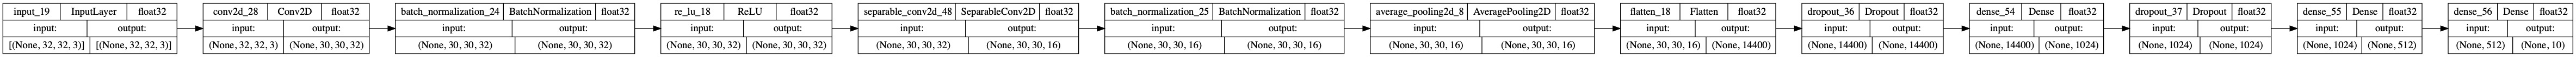



HiveNAS+ACT's top architecture (input|sc_2|avg_pool3x3|sep3x3_128|batch_norm|sc_1|sep3x3_64|sep5x5_32|output)



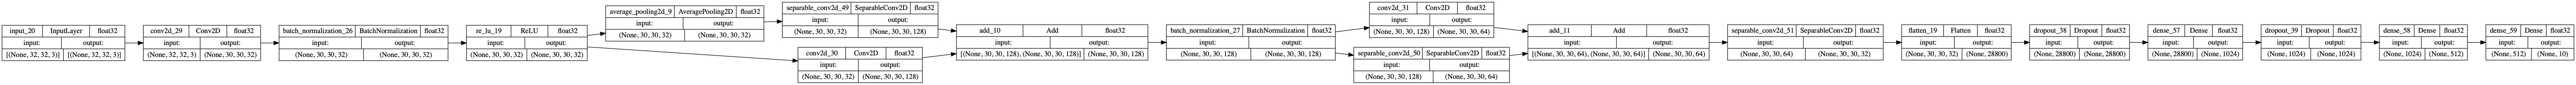

In [54]:
''' Visualize best performing architectures '''

# Indices included in this analysis
dfs_idx = [0,1,2,3,4]

for (idx, (k, df)) in enumerate(main_dfs.items()):
    if idx not in dfs_idx:
        continue
    
    top_model = main_dfs[k]['data']['fitness'].idxmax()
    arch_str = main_dfs[k]['data'].iloc[[top_model]]['candidate'].values[0]
    # bare bones model
    model, in_shape = instantiate_network(arch_str)
    model.build(in_shape)
    f_name = ANALYSIS_RESULTS_PATH + f'{main_dfs[k]["name"]}_arch.jpg'
    plot_model(model, to_file=f_name, show_shapes=True, show_dtype=True, rankdir="LR")
    print(f'{main_dfs[k]["name"]}\'s top architecture ({arch_str})\n')
    display(Image(retina=True, filename=f_name))
    print('\n')

#### Augmentation Improvement
*Augmentation & Cutout improvements*

In [55]:
''' Showcases the generalization capabilities Augmentation and Cutout models offer '''

# Indices included in this analysis
dfs_idx = [0, 1, 3]

# Data manipulation
train_test = {}
for (idx, (k, df)) in enumerate(main_dfs.items()):
    if idx not in dfs_idx:
        continue
        
    if main_dfs[k]['hist'].empty:
        print(f'Skipping {main_dfs[k]["name"]}, no training history files found...\n')
        continue
    
    main_dfs[k]['hist']['train_test_gap'] = main_dfs[k]['hist']['val_sparse_categorical_accuracy'] - main_dfs[k]['hist']['sparse_categorical_accuracy']
    grouped = main_dfs[k]['hist'].groupby(['arch'])['train_test_gap'].mean().values
    grouped = reject_outliers(grouped)
    train_test[main_dfs[k]['name']] = grouped

# Truncate data lengths to match (for aesthetic purposes)
truncate_lists(train_test)

# Figure customization
fig = go.Figure()
fig.update_layout(
    title='Validation / Training Percent Difference',
    xaxis_title='Neural Architecture Index', 
    yaxis_title='Generalization Improvement',
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=500
)

fig.update_yaxes(tickformat=',.0%',
                 # flatten data for range extrapolation
                 range=[min([item for _,ls in train_test.items() for item in ls]) * 1.1, 
                        max([item for _,ls in train_test.items() for item in ls]) * 1.225],
                 color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)

fig.update_xaxes(color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)

for idx, (name, trace_data) in enumerate(train_test.items()):
    # Traces
    fig.add_trace(go.Scatter(x=list(range(len(trace_data))), y=trace_data,
                             mode='lines',
                             name=name,
                             line=dict(color=TRACE_COLORS[idx])))
    fig.add_trace(go.Scatter(x=list(range(len(trace_data))), y=[trace_data.mean() for _ in range(len(trace_data))],
                             mode='lines',
                             name=f'{name} (mean)',
                             line=dict(color=TRACE_DOTTED_COLORS[idx], dash='dot')))


fig.write_image(ANALYSIS_RESULTS_PATH + 'augmentation_improvement.eps')

fig.show()

#### Augmentation Performance Impact
*Augmentation & Cutout impact on performance (resource-intensive image manipulation)*

In [56]:
''' Although Aug. and Cutout significiantly prevent overfitting, they dramatically increase training time '''

# Indices included in this analysis
dfs_idx = [0, 1, 3]

# Data manipulation
time_impact = {}
for (idx, (k, df)) in enumerate(main_dfs.items()):
    if idx not in dfs_idx:
        continue
        
    if main_dfs[k]['data'].empty:
        print(f'Skipping {main_dfs[k]["name"]}, no main data file found...\n')
        continue
        
    time_impact[main_dfs[k]['name']] = main_dfs[k]['data']['time'].values

# Truncate data lengths to match (for aesthetic purposes)
truncate_lists(time_impact)

# Figure customization
fig = go.Figure()
fig.update_layout(
    title='Augmentation Performance Impact',
    xaxis_title='Neural Architecture Index', 
    yaxis_title='Processing Time (s)',
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=500
)

fig.update_yaxes(color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)

fig.update_xaxes(color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)


for idx, (name, trace_data) in enumerate(time_impact.items()):
    # Traces
    fig.add_trace(go.Scatter(x=list(range(len(trace_data))), y=trace_data,
                             mode='lines',
                             name=name,
                             line=dict(color=TRACE_COLORS[idx])))
    fig.add_trace(go.Scatter(x=list(range(len(trace_data))), y=[trace_data.mean() for _ in range(len(trace_data))],
                             mode='lines',
                             name=f'{name} (mean)',
                             line=dict(color=TRACE_DOTTED_COLORS[idx], dash='dot')))


fig.write_image(ANALYSIS_RESULTS_PATH + 'aug_performance_impact.eps')

fig.show()



#### Convergence Profile
*Skip-Connections' convergence stability*

In [57]:
''' Showcases the convergence stability (low loss std.) of skip-connections/resnets '''

# Indices included in this analysis
dfs_idx = [0, 2]

# Data Prep.
def group_avg_roc(tpl):
    return abs((tpl[-1] - tpl[0]) / len(tpl))

CONVERGENCE_METRIC = 'loss'    # 'loss', 'val_loss', 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'

avg_roc = {}
for (idx, (k, df)) in enumerate(main_dfs.items()):
    if idx not in dfs_idx:
        continue
        
    if main_dfs[k]['hist'].empty:
        print(f'Skipping {main_dfs[k]["name"]}, no history files found...\n')
        continue
        
    avg_roc[main_dfs[k]['name']] = [group_avg_roc(group[1].values) for group in main_dfs[k]['hist'].groupby('arch')['val_loss']]
    

    avg_roc[main_dfs[k]['name']] = reject_outliers(np.array(avg_roc[main_dfs[k]['name']]), m=2)
    
# Truncate data lengths to match (for aesthetic purposes)
truncate_lists(avg_roc)

# Figure customization
fig = go.Figure()
fig.update_layout(
    title='Convergence Profile',
    xaxis_title='Neural Architecture Index', 
    yaxis_title='Mean Loss Rate of Change',
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=500
)

fig.update_yaxes(color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)

fig.update_xaxes(color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)

# Traces
for idx, (name, trace_data) in enumerate(avg_roc.items()):
    # Traces
    fig.add_trace(go.Scatter(x=list(range(len(trace_data))), y=trace_data,
                             mode='lines',
                             name=name,
                             line=dict(color=TRACE_COLORS[idx])))
    fig.add_trace(go.Scatter(x=list(range(len(trace_data))), y=[trace_data.mean() for _ in range(len(trace_data))],
                             mode='lines',
                             name=f'{name} (mean)',
                             line=dict(color=TRACE_DOTTED_COLORS[idx], dash='dot')))

fig.write_image(ANALYSIS_RESULTS_PATH + 'convergence_profile.eps')

fig.show()

# print([i[0] for i in hist_df_a.groupby('arch')['val_loss']])
# print(hist_df_a.groupby('arch')['val_loss'].get_group('input|avg_pool3x3|sep3x3_128|avg_pool3x3|sep5x5_32|output'),'\n\n')
# print(hist_df_a.groupby('arch')['val_loss'].get_group('input|batch_norm|sep3x3_128|avg_pool3x3|sep5x5_32|output'))

In [58]:
''' Mean Loss rate of change STD '''

models = ['HiveNAS', 'HiveNAS+ResNets']
print(f'{models[0]} Mean Loss Rate of Change (standard deviation):         {avg_roc[models[0]].std()} --> Jittery convergence',
      f'\n{models[1]} Mean Loss Rate of Change (standard deviation): {avg_roc[models[1]].std()} --> More stable convergence')

HiveNAS Mean Loss Rate of Change (standard deviation):         0.029853405406769645 --> Jittery convergence 
HiveNAS+ResNets Mean Loss Rate of Change (standard deviation): 0.007183617852890493 --> More stable convergence


In [59]:
main_dfs['baseline']['data']['accu_time'] = main_dfs['baseline']['data']['time'].cumsum(axis=0)
main_dfs['baseline']['data']['accu_time']


0       96.206304
1      190.141216
2      275.263164
3      353.505394
4      394.351538
         ...     
58    4141.771364
59    4243.043017
60    4297.130140
61    4342.990510
62    4391.601850
Name: accu_time, Length: 63, dtype: float64

#### ACT Time Impact

In [60]:
''' ACT model time-improvement '''

# Indices included in this analysis
dfs_idx = [1, 3, 4]

truncate_till_hours = 1     # number of candidates evaluated in n hours

# Data manipulation
time_impact = {}
for (idx, (k, df)) in enumerate(main_dfs.items()):
    if idx not in dfs_idx:
        continue
        
    if main_dfs[k]['data'].empty:
        print(f'Skipping {main_dfs[k]["name"]}, no main data file found...\n')
        continue
    
    time_impact[main_dfs[k]['name']] = [candidate for candidate in main_dfs[k]['data']['time'].cumsum(axis=0).values if candidate <= truncate_till_hours * 60 * 60]

# Rename ACT for clarity
time_impact['HiveNAS+Aug+Cutout+ACT'] = time_impact.pop('HiveNAS+ACT')

# Figure customization
fig = go.Figure()
fig.update_layout(
    title='ACT Performance Boost',
    xaxis_title='Model', 
    yaxis_title=f'# Candidates Evaluated in {truncate_till_hours} hour',
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=500
)

fig.update_yaxes(color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)

fig.update_xaxes(color=PLOT_TEXT_COLOR,
                 zeroline=True,
                 zerolinewidth=1,
                 zerolinecolor=GRID_ZERO_LINE_COLOR,
                 gridcolor=GRID_LINE_COLOR)


fig.add_trace(go.Bar(x=list(time_impact.keys()), y=[len(bar_data) for k, bar_data in time_impact.items()],
                    marker_color=TRACE_COLORS[1]))


fig.write_image(ANALYSIS_RESULTS_PATH + 'act_performance_impact.eps')

fig.show()

